# Collaboration and Competition

---

Train a pair of agents to play tennis.

### 1. Start the Environment

Begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name = "Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here, we check for the first brain available & set it as the default brain we'll be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

***(Uncomment the code to try)***

Next, use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, we'll watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

In [5]:
#for i in range(1, 6):                                      # play game for 5 episodes
#    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
#    states = env_info.vector_observations                  # get the current state (for each agent)
#    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
#    
#    while True:
#        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
#        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
#        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
#        next_states = env_info.vector_observations         # get next state (for each agent)
#        rewards = env_info.rewards                         # get reward (for each agent)
#        dones = env_info.local_done                        # see if episode finished
#        scores += env_info.rewards                         # update the score (for each agent)
#        states = next_states                               # roll over states to next time step
        
#        if np.any(dones):                                  # exit loop if episode finished
#            break
            
#    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

When finished, you can close the environment.

In [6]:
# env.close() # avoid closing to further train the agent on environment with DQN

## 4. MADDPG implementation

This implementation deals with making the agent to be able to use its experience to gradually choose better actions when interacting with the environment!

Unlike the previous run, when training the environment, `train_mode = True` should be set:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

The MADDPG agent uses multiple DDPG agents which solves the environment by playing against each other. The task is episodic, and in order to solve the environment, the agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically,

- After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
- This yields a single score for each episode.

#### 4.1 Import some necessary packages

In [7]:
#Some packages may be already imported
from agent import MADDPGAgent
from collections import deque
import torch

import matplotlib.pyplot as plt
%matplotlib inline

#### 4.2 Define a MADDPG model

Run the code cell below to train the agent from scratch or skip to the next step **Instantiate the Agent** & then **4.3 Watch a Smart Agent!**, to load the saved weights from a pre-trained agent & watch the agent.

Alternatively, load the model along with the saved weights into a different solution file such that one doesn't need to build a model from scratch.

In [9]:
def maddpg(agent, epochs = 5000, print_every = 10):
    
    scores = []                                                       # list containing scores from each episode
    scores_window = deque(maxlen = 100)                               # last 100 scores
    # avg_scores_list = []                                            # initialize to plot average score graph
    
    for i_episode in range(1, epochs + 1):
        env_info = env.reset(train_mode = True)[brain_name]           # reset the environment    
        states = env_info.vector_observations                         # get the current state (for each agent)
        agent.reset()                                                 # use when add_noise = True
        score = np.zeros(num_agents)                                  # initialize the score (for each agent)
        
        # for each agent
        while True: 
            actions = agent.act(states, add_noise = True)             # select actions 
            env_info = env.step(actions)[brain_name]                  # send actions to the environment
            next_states = env_info.vector_observations
            rewards = env_info.rewards         
            dones = env_info.local_done                               
            agent.step(states, actions, rewards, next_states, dones)  # append experience to buffer
            
            states = next_states                                      # roll over state to next time step
            score += rewards                                          # update the scores  

            if any(dones):                                            # see if episode for any agents finishes
                break

        score_max = np.max(score)
        scores_window.append(score_max)
        scores.append(score_max)
        # average_score = np.mean(scores_window)
        # average_scores.append(average_score)

        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if (i_episode % print_every == 0):
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, np.mean(scores_window)))
            
        if (np.mean(scores_window) >= 0.5 and i_episode > 100):
            print('Problem Solved in {} episodes\tAverage score: {:.4f}'.format(i_episode - 100, np.mean(scores_window)))
            agent.save_weights()
            break
            
    return scores

**Instantiate the agent**

In [8]:
agent = MADDPGAgent(state_size = 24 , action_size = 2, num_agents = num_agents, seed = 0)

**Train the agent**

In [11]:
scores = maddpg(agent)

Episode 10	Average Score: 0.0000
Episode 20	Average Score: 0.0000
Episode 30	Average Score: 0.0000
Episode 40	Average Score: 0.0000
Episode 50	Average Score: 0.0096
Episode 60	Average Score: 0.0127
Episode 70	Average Score: 0.0109
Episode 80	Average Score: 0.0095
Episode 90	Average Score: 0.0084
Episode 100	Average Score: 0.0076
Episode 110	Average Score: 0.0076
Episode 120	Average Score: 0.0076
Episode 130	Average Score: 0.0076
Episode 140	Average Score: 0.0076
Episode 150	Average Score: 0.0028
Episode 160	Average Score: 0.0000
Episode 170	Average Score: 0.0000
Episode 180	Average Score: 0.0000
Episode 190	Average Score: 0.0000
Episode 200	Average Score: 0.0000
Episode 210	Average Score: 0.0000
Episode 220	Average Score: 0.0000
Episode 230	Average Score: 0.0000
Episode 240	Average Score: 0.0000
Episode 250	Average Score: 0.0000
Episode 260	Average Score: 0.0000
Episode 270	Average Score: 0.0000
Episode 280	Average Score: 0.0000
Episode 290	Average Score: 0.0000
Episode 300	Average Sco

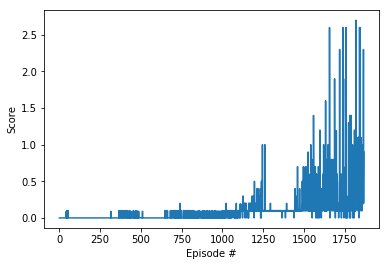

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

#### 4.3 Watch a Smart Agent

Load the trained weights from file to watch a smart agent!

In [9]:
agent.load_weights()

In [10]:
env_info = env.reset(train_mode = False)[brain_name]     # reset the environment    
states = env_info.vector_observations                    # get the current state (for each agent)
scores = np.zeros(num_agents)                            # initialize the score (for each agent)
while True:
    actions = agent.act(states, add_noise = False)     # select actions
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    
    states = next_states                               # roll over states to next time step
    scores += rewards                                  # update the score (for each agent)

    if np.any(dones):                                  # exit loop if episode finished
        break

env.close()

print("Max score: {:.2f}".format(max(scores)))

C:\Users\BlackHat\Anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Max score: 2.60
